In [1]:
#default_exp collaborative_filtering

In [2]:
#export
import os

import numpy as np
import pandas as pd
import scipy

import torch

import itertools
from functools import partial
import attr

import fastai
from fastai import collab, tabular
import implicit
from sklearn import compose, preprocessing, metrics
import fastFM.sgd
import fastFM.als
import tqdm
import seaborn as sns

import matplotlib.pyplot as plt

from mlutil.misc import one_hot_encoder_column_transformer

from game_recommender import steam_data
from mlutil import recommendation


np.random.seed(0)

/etc/conda/envs/ml/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_extraction.stop_words module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_extraction.text. Anything that cannot be imported from sklearn.feature_extraction.text is now part of the private API.
  warnings.warn(message, FutureWarning)


# Collaborative filtering

In this notebook recommendation algorithms are trained on 'log_hours' column.

I used this feature because in absence of ratings it can serve as feedback whether user liked a game.

In [3]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.core.common.SettingWithCopyWarning)

In [4]:

%cd ..
%matplotlib inline

/home/kuba/Projects/game_recommender


In [6]:
raw_steam_ratings_df = steam_data.load_steam_ratings_df()

## Filtering data

We need to exclude games and users with low number of reviews - for users with insufficient number of reviewed games the estimates will be very unstable

In [7]:
steam_ratings_df = steam_data.filter_ratings_with_metadata(raw_steam_ratings_df)

In [8]:
steam_ratings_df.head()

,user_id,name,ownership,hours,log_hours,played,interacted,name_unnormalized
1,151603712,fallout 4,purchase,1.0,0.693147,0,1,Fallout 4
2,151603712,fallout 4,play,87.0,4.477337,1,1,Fallout 4
3,151603712,spore,purchase,1.0,0.693147,0,1,Spore
4,151603712,spore,play,14.9,2.766319,1,1,Spore
5,151603712,fallout new vegas,purchase,1.0,0.693147,0,1,Fallout New Vegas


In [9]:
import pickle

game_dataset_pickle_path = 'data/game_dataset.pkl'
if os.path.exists(game_dataset_pickle_path):
    game_dataset_raw = pickle.load(open(game_dataset_pickle_path, 'rb'))
else:
    steam_ratings_df = steam_data.filter_ratings_with_metadata(raw_steam_ratings_df)
    game_dataset_raw = steam_data.RecommenderDataset.make_implicit_feedback_dataset(steam_ratings_df)
    pickle.dump(game_dataset_raw, open(game_dataset_pickle_path, 'wb'))

game_dataset = (
    game_dataset_raw
    .filter_out_insufficient_reviews('user_id', 5)
    .filter_out_insufficient_reviews('name', 2)
)

In [10]:
game_dataset = (
        game_dataset_raw
        .filter_out_insufficient_reviews('user_id', 5)
        .filter_out_insufficient_reviews('name', 2)
    )

In [11]:
game_dataset.data.shape

(71630, 7)

In [12]:
steam_dataset, target = game_dataset.data, game_dataset.target

In [13]:
min_review_threshold = 3

In [15]:
raw_user_review_counts = steam_dataset.groupby('user_id').agg('count').iloc[:,0]
(raw_user_review_counts > min_review_threshold).mean()

1.0

In [16]:
game_review_counts = steam_dataset.groupby('name').agg('count').iloc[:,0]

## Number of games

In [17]:
steam_dataset['name'].nunique()

2261

In [18]:
steam_dataset['name'].value_counts().describe()

count    2261.000000
mean       31.680672
std        77.919528
min         2.000000
25%         4.000000
50%         9.000000
75%        28.000000
max      1232.000000
Name: name, dtype: float64

## Number of users 

In [19]:
steam_dataset['user_id'].nunique()

2869

In [20]:
steam_dataset['user_id'].value_counts().describe()

count    2869.000000
mean       24.966887
std        41.936376
min         4.000000
25%         7.000000
50%        11.000000
75%        24.000000
max       616.000000
Name: user_id, dtype: float64

## Predicted column - log_hours

In [21]:
target.describe()

count    71630.000000
mean         1.528102
std          1.393734
min          0.095310
25%          0.693147
50%          0.693147
75%          2.174752
max          9.253687
Name: log_hours, dtype: float64

In [22]:
steam_dataset.shape

(71630, 7)

## Games played per user 

Max number of played games was truncated at $q = 95$ percentile 

95% users rated less than 91.0 games


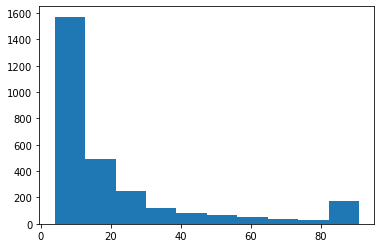

In [59]:
user_review_counts = steam_dataset.groupby('user_id').agg('count').iloc[:,0]
q = user_review_counts.quantile(0.95)
truncated_review_counts = np.minimum(user_review_counts, q)
print('95% users rated less than', q , 'games')
plt.hist(truncated_review_counts);

In [60]:
# Games play counts

95% games were played less than 129.0 times


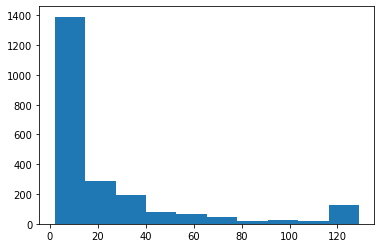

In [62]:
user_review_counts = steam_dataset.groupby('name').agg('count').iloc[:,0]
q = user_review_counts.quantile(0.95)
truncated_review_counts = np.minimum(user_review_counts, q)
print('95% games were played less than', q , 'times')
plt.hist(truncated_review_counts);

# Train test split

Splitting is nontrivial matter here: different algorithms use different encoding schemes:
        
- Factorization Machines and FastAI collaborative filtering use supervised learning convention (inputs are one-hot encoded user and item columns)
- Matrix Factorization algorithms use user-item matrix

In [24]:
from sklearn import model_selection

labels_train, labels_val = model_selection.train_test_split(
    range(len(steam_dataset)),
    stratify=steam_dataset['user_id'],
    test_size=0.2
)

In [25]:
import scipy


def encode_user_item_matrix(steam_dataset, target):
    ratings_df = steam_dataset.copy()
    ratings_df['target'] = target
    item_user_pivoted_df = ratings_df.pivot_table(index='name', columns='user_id', values='target')
    item_user_matrix = scipy.sparse.csr_matrix(item_user_pivoted_df.fillna(0).values)
    return scipy.sparse.csr_matrix(item_user_matrix.T)


user_game_matrix_train = encode_user_item_matrix(steam_dataset.iloc[labels_train], target)
user_game_matrix_val = encode_user_item_matrix(steam_dataset.iloc[labels_val], target)
user_game_matrix_train.shape, user_game_matrix_val.shape

((2869, 2241), (2869, 1729))

In [26]:
def get_prediction_spearman_correlation(target, predictions, agg_col):
    # ignore warnings for users with one rated item
    with warnings.catch_warnings(record=True) as w:
        warnings.simplefilter("ignore")
        eval_df = pd.DataFrame({
            'target': target,
            'predictions': predictions,
        }
        ) 
        corr_df = eval_df.groupby(agg_col).agg(
            lambda df: scipy.stats.spearmanr(
                df['target'], df['predictions'])[0]
        ).iloc[:,0]
    return corr_df


def summarize_per_user_correlations(evaluation_df, target_col, pred_col, agg_col='user_id', alpha=0.5, implicit_feedback_threshold=0.5):
    spearman_correlations = get_prediction_spearman_correlation(evaluation_df[target_col], evaluation_df[pred_col], evaluation_df[agg_col])
    sns.lmplot(data=evaluation_df, x=pred_col, y=target_col, line_kws={'color': 'red'});
    plt.title('target vs prediction')
    plt.show()
    error = evaluation_df[target_col] - evaluation_df[pred_col]
    implicit_feedback_loss_scaling = (1 + alpha * (evaluation_df[target_col] > implicit_feedback_threshold))
    print('MAE: {:,.3f}'.format(np.mean(np.abs(error))))
    print('MSE: {:,.3f}'.format(np.mean(error ** 2)))
    print('Implicit feedback MSE loss: {:,.3f}'.format(np.mean(implicit_feedback_loss_scaling * (error ** 2))))
    sns.distplot(error, kde=False);
    plt.title('error distribution')
    plt.show()
    plt.title('per-user mean Spearman correlation {:,.3f}'.format(spearman_correlations.mean()))
    spearman_correlations.plot.hist()
    return spearman_correlations

# FastAI Collaborative Filtering model

In [27]:
steam_datasetbunch = (
    collab.CollabList.from_df(
        pd.concat([steam_dataset, target], axis=1),
        cat_names=['user_id', 'name'],
        procs=tabular.Categorify)
    .split_by_idxs(labels_train, labels_val)
    .label_from_df('log_hours')
).databunch(path=None, bs=64)

In [28]:
#export
from torch.functional import F


def flat_smooth_l1_loss(input, labels, reduction=None):
    """
    l1 loss of flattened predictions 
    """
    return torch.nn.SmoothL1Loss(reduction=reduction)(input.reshape(-1), labels)


def flat_implicit_feedback_loss(input, labels, loss=flat_smooth_l1_loss, alpha=0.5, bias=10):
    r = torch.nn.Sigmoid()(labels + bias)
    return ((1 + alpha * r) * loss(input, labels, reduction='none')).mean()

In [29]:
nn_cf_learner =  collab.collab_learner(
    steam_datasetbunch,
    y_range=(0,10),
    emb_drop=0.5,
    use_nn=True,
    layers=[10, 10],
    loss_func=flat_implicit_feedback_loss,
)

In [30]:
nn_cf_learner.lr_find()

epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 4.79E-02
Min loss divided by 10: 3.31E-01


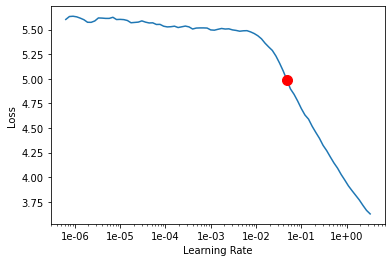

In [31]:
nn_cf_learner.recorder.plot(suggestion=True)

In [32]:
nn_cf_learner.fit_one_cycle(
    5, max_lr=1e-3,
)

epoch,train_loss,valid_loss,time
0,1.696637,1.512649,00:04
1,0.795009,0.767187,00:04
2,0.658930,0.665206,00:04
3,0.625567,0.662223,00:04
4,0.604218,0.662673,00:04


In [33]:
nn_cf_learner.show_results(rows=50)

user_id,name,target,prediction
167013261,half life,0.6931472,[0.735151]
71390526,sid meiers civilization 4,1.9600948,[2.190101]
71777065,wolfenstein the new order,3.4011974,[1.449394]
43955374,section 8 prejudice,1.9315214,[1.718276]
31669242,just cause,0.6931472,[0.746586]
168641975,goat simulator,0.53062826,[0.960141]
43684632,metal gear solid 5 the phantom pain,4.564348,[3.607436]
60859695,dungeon defenders,1.5892352,[1.462793]
35701646,uplink,0.6931472,[0.845477]
22301321,hotline miami,0.6931472,[0.863658]


In [34]:
nn_preds_val = nn_cf_learner.get_preds()

In [35]:
target_val = target[labels_val]

In [36]:
evaluation_df = steam_dataset.iloc[labels_val]
evaluation_df['target'] = target
evaluation_df['nn_preds'] = nn_preds_val[0].numpy().reshape(-1)

In [37]:
evaluation_df

,user_id,name,ownership,hours,played,interacted,name_unnormalized,target,nn_preds
36230,167013261,half life,purchase,1.0,0,1,Half-Life,0.693147,0.735151
62880,71390526,sid meiers civilization 4,play,6.1,1,1,Sid Meier's Civilization IV,1.960095,2.190101
84068,71777065,wolfenstein the new order,play,29.0,1,1,Wolfenstein The New Order,3.401197,1.449394
61870,43955374,section 8 prejudice,play,5.9,1,1,Section 8 Prejudice,1.931521,1.718276
42595,31669242,just cause,purchase,1.0,0,1,Just Cause,0.693147,0.746586
...,...,...,...,...,...,...,...,...,...
37021,12130111,half life 2 deathmatch,purchase,1.0,0,1,Half-Life 2 Deathmatch,0.693147,0.731865
31416,72978546,fistful of frags,purchase,1.0,0,1,Fistful of Frags,0.693147,0.959285
1028,65909415,alan wake,play,14.5,1,1,Alan Wake,2.740840,0.780895
15140,296979815,counter strike nexon zombies,play,0.5,1,1,Counter-Strike Nexon Zombies,0.405465,0.748528


In [38]:
evaluation_df['nn_preds']

36230    0.735151
62880    2.190101
84068    1.449394
61870    1.718276
42595    0.746586
           ...   
37021    0.731865
31416    0.959285
1028     0.780895
15140    0.748528
191      3.144693
Name: nn_preds, Length: 14326, dtype: float32

In [39]:
get_prediction_spearman_correlation(evaluation_df['target'], evaluation_df['nn_preds'], evaluation_df['user_id'])

user_id
5250         0.258199
76767        0.359092
86540       -0.198030
103360            NaN
144736      -1.000000
               ...   
303129589    0.866025
303525289         NaN
304971849    1.000000
306547522         NaN
309404240         NaN
Name: target, Length: 2869, dtype: float64

In [40]:
evaluation_df['user_id']

36230    167013261
62880     71390526
84068     71777065
61870     43955374
42595     31669242
           ...    
37021     12130111
31416     72978546
1028      65909415
15140    296979815
191      173453295
Name: user_id, Length: 14326, dtype: int64

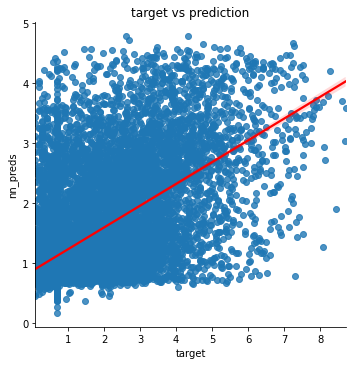

MAE: 0.741
MSE: 1.300
Implicit feedback MSE loss: 1.950


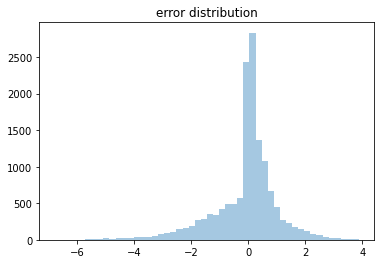

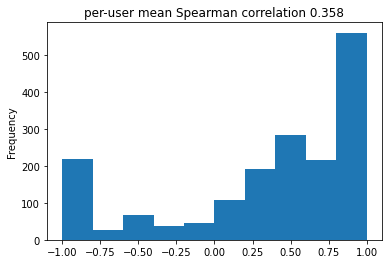

In [41]:
nn_spearman_correlations = summarize_per_user_correlations(
    evaluation_df,
    'nn_preds',
    'target'
)

# Factorization Machines

In [42]:
fm_coltransformer = one_hot_encoder_column_transformer(['user_id', 'name'])

In [43]:
X_fm = fm_coltransformer.fit_transform(steam_dataset)
X_fm_train = X_fm[labels_train]
X_fm_val = X_fm[labels_val]

y_train = target.iloc[labels_train]
y_val = target.iloc[labels_val]
user_id_val = steam_dataset['user_id']

In [44]:
def run_fm_experiments(
        fm_cls, ranks,
        n_iters,
        data_train=(X_fm_train, y_train),
        data_val=(X_fm_val, y_val, user_id_val),
        **kwargs
    ):
    fm_sgd_results = []
    best_model = None
    best_corr = 0 
    
    for (rank, n_iter) in tqdm.tqdm(
        itertools.product(ranks, n_iters),
        total=len(ranks) * len(n_iters)
    ):
        init_stdev = kwargs.pop('init_stdev') if  kwargs.get('init_stdev') else 1/rank
        fm_model = fm_cls(rank=rank, n_iter=n_iter, init_stdev=1/rank, **kwargs)
        fm_model.fit(*data_train)

        train_error = metrics.mean_squared_error(data_train[1], fm_model.predict(data_train[0]))
        val_error = metrics.mean_squared_error(data_val[1], fm_model.predict(data_val[0]))
    
        spearman_corr = get_prediction_spearman_correlation(
            data_val[1], fm_model.predict(data_val[0]), user_id_val 
        ).mean()
    
        fm_sgd_results.append({'n_factors': rank, 'n_iter': n_iter, 'train_error': train_error, 'val_error': val_error, 'val_spearman_correlation': spearman_corr})
        if best_corr > spearman_corr or best_model is None:
            best_val_error = val_error
            best_model = fm_model
    return round(pd.DataFrame(fm_sgd_results), 3), fm_model

In [45]:
fm_sgd_ranks = [25, 50, 100, 250, 500]
fm_sgd_n_iters = range(5000, 10000+ 1, 1000)


fm_sgd_results, fm_sgd_model = run_fm_experiments(fastFM.sgd.FMRegression, fm_sgd_ranks, fm_sgd_n_iters, l2_reg=0.1)

100%|██████████| 30/30 [00:59<00:00,  1.98s/it]


## runs with n_factors maximizing Spearman correlation 

In [46]:
best_n_iter_results_df = pd.DataFrame(fm_sgd_results).groupby('n_factors').agg(lambda df: df[df['val_error'] == df['val_error'].min()].iloc[0])

best_n_iter_results_df

,n_iter,train_error,val_error,val_spearman_correlation
n_factors,,,,
25,8000.0,1.378,1.430,0.319
50,8000.0,1.380,1.430,0.323
100,8000.0,1.381,1.431,0.324
250,8000.0,1.381,1.431,0.324
500,8000.0,1.381,1.431,0.325


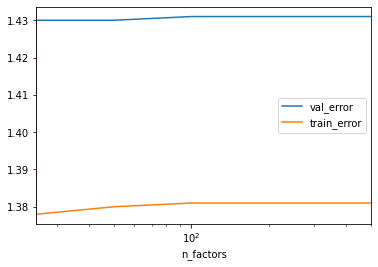

In [47]:
best_n_iter_results_df[['val_error', 'train_error']].plot()
plt.axvline(best_n_iter_results_df['val_error'].idxmin() , c='red')
plt.xscale('log');

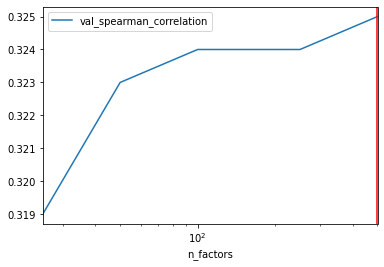

In [48]:
best_n_iter_results_df[['val_spearman_correlation']].plot()
plt.axvline(best_n_iter_results_df['val_spearman_correlation'].idxmax() , c='red')
plt.xscale('log');

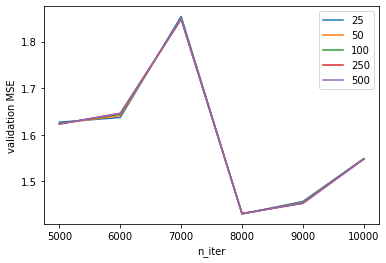

In [49]:
for rank in fm_sgd_ranks:
    fm_rank_results_df = fm_sgd_results[fm_sgd_results['n_factors'] == rank] 
    plt.plot(fm_rank_results_df['n_iter'], fm_rank_results_df['val_error'], label=str(rank))
    plt.legend()
    plt.ylabel('validation MSE')
    plt.xlabel('n_iter')

In [50]:
fm_sgd_pred = fm_sgd_model.predict(X_fm_val)

evaluation_df['fm_sgd_preds'] =  fm_sgd_pred

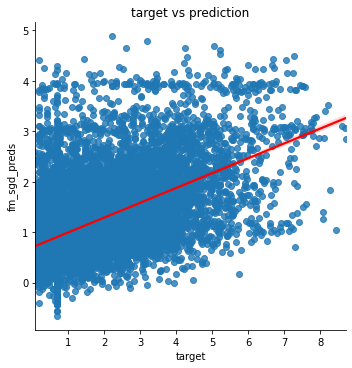

MAE: 0.850
MSE: 1.548
Implicit feedback MSE loss: 2.267


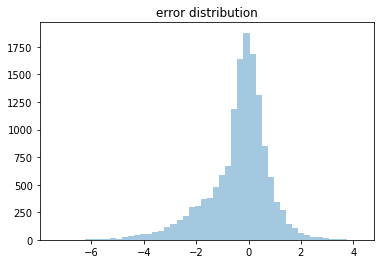

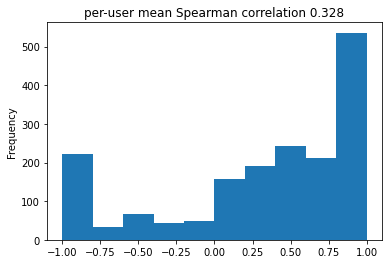

In [51]:
fm_sgd_spearman_correlations = summarize_per_user_correlations(evaluation_df, 'fm_sgd_preds', 'target')

# Factorization machines trained with Alternating Least Squares

In [52]:
fm_als_ranks = [5, 25, 50, 100, 250]
fm_als_n_iters = [10, 25, 50, 100]#, 100] 

fm_als_results, fm_als_model = run_fm_experiments(
    fastFM.als.FMRegression, fm_als_ranks,
    fm_als_n_iters,
    l2_reg=25.0
)

100%|██████████| 20/20 [02:36<00:00,  7.83s/it]


In [53]:
best_n_iter_results_df = pd.DataFrame(fm_als_results).groupby('n_factors').agg(lambda df: df[df['val_spearman_correlation'] == df['val_spearman_correlation'].min()].iloc[0])
best_n_iter_results_df

,n_iter,train_error,val_error,val_spearman_correlation
n_factors,,,,
5,10.0,0.924,1.265,0.362
25,25.0,0.885,1.262,0.356
50,25.0,0.885,1.262,0.357
100,25.0,0.885,1.262,0.357
250,10.0,0.896,1.264,0.357


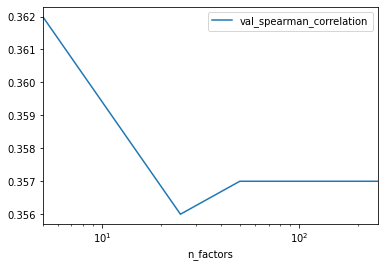

In [54]:
best_n_iter_results_df[['val_spearman_correlation']].plot()
plt.xscale('log');

In [55]:
fm_als_ranks

[5, 25, 50, 100, 250]

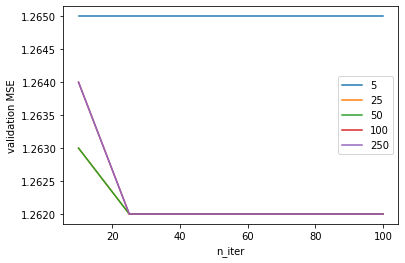

In [56]:
for rank in fm_als_ranks:
    fm_rank_results_df = fm_als_results[fm_als_results['n_factors'] == rank] 
    plt.plot(fm_rank_results_df['n_iter'], fm_rank_results_df['val_error'], label=str(rank))
    plt.legend()
    plt.ylabel('validation MSE')
    plt.xlabel('n_iter')

In [57]:
fm_als_pred = fm_als_model.predict(X_fm_val)
evaluation_df['fm_als_preds'] =  fm_als_pred

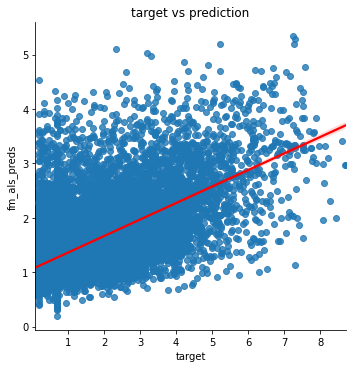

MAE: 0.811
MSE: 1.262
Implicit feedback MSE loss: 1.893


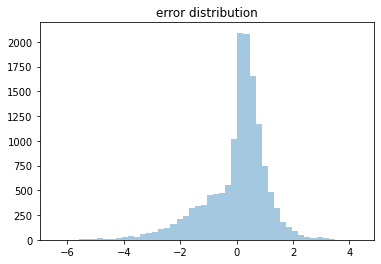

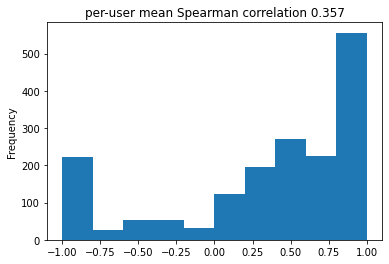

In [58]:
fm_als_spearman_correlations = summarize_per_user_correlations(evaluation_df, 'fm_als_preds', 'target')

In [73]:
steam_dataset['user_id'].nunique() + steam_dataset['name'].nunique()

5130

2261

In [70]:
fm_als_model.V_.shape

(250, 5130)

# Catboost

In [ ]:
import catboost

catboost_model = catboost.CatBoostRegressor(
    learning_rate=0.01,
    iterations=5000
)

In [ ]:
X_catboost = steam_dataset[['user_id', 'name']]
X_catboost_train = X_catboost.iloc[labels_train]
X_catboost_val = X_catboost.iloc[labels_val]

In [ ]:
catboost_model.fit(
    X_catboost_train,
    y_train,
    eval_set=(X_catboost_val, y_val),
    cat_features=['user_id', 'name']
)

In [ ]:
catboost_pred = catboost_model.predict(X_catboost_val)
evaluation_df['catboost_preds'] =  catboost_pred

In [ ]:
catboost_spearman_correlations = summarize_per_user_correlations(evaluation_df, 'catboost_preds', 'target')

# Comparing predictions across models

In [ ]:
sns.heatmap(evaluation_df[[col for col in evaluation_df.columns if col == 'target' or 'pred' in col]].corr(), cmap='gray');

# Embarassingly Shallow Autoencoder

Model from [Embarrassingly Shallow Autoencoders for Sparse Data](https://arxiv.org/pdf/1905.03375.pdf)

In [ ]:
n_experiments = 10 
lambdas = np.logspace(0, 3, n_experiments)
losses = np.empty_like(lambdas)

In [ ]:
user_game_matrix_train, user_game_matrix_val = steam_dataset.get_item_user_matrix_train_val_split(
    game_dataset,
    labels_train,
    labels_val
)

In [ ]:
for i, lambda_ in tqdm.tqdm(enumerate(lambdas), total=n_experiments):
    esa = recommendation.EmbarrasinglyShallowAutoencoder(lambda_)
    esa.fit(user_game_matrix_train)
    loss = esa.score_reconstruction(user_game_matrix_val.toarray())
    losses[i] = loss 

In [ ]:
lambdas[losses.argmin()], losses.min()

In [ ]:
i = 10 
plt.plot(lambdas, losses)
plt.xscale('log');
plt.axvline(lambdas[losses.argmin()], c='red')
plt.xlabel('l2 regularization strength')
plt.ylabel('MSE');

In [ ]:
best_regularization_strength = lambdas[losses.argmin()]
esa = recommendation.EmbarrasinglyShallowAutoencoder(best_regularization_strength)
esa.fit(user_game_matrix_train)